In [2]:
from sklearn_preprocessing.gauss_rank_scaler import *
import pandas as pd
from sklearn.datasets import load_boston
%matplotlib inline

In [8]:
bunch = load_boston()

y_train = bunch.target[:250]
y_test = bunch.target[250:]

X_train = pd.DataFrame(bunch.data[:250], columns=bunch.feature_names)
X_test = pd.DataFrame(bunch.data[250:], columns=bunch.feature_names)

In [9]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


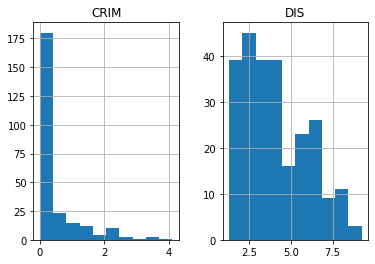

In [13]:
_ = X_train[['CRIM', 'DIS']].hist()

In [27]:
gauss_rank_scaler = GuassRankScaler()
X_train_new = gauss_rank_scaler.fit_transform(X_train[['CRIM', 'DIS']])

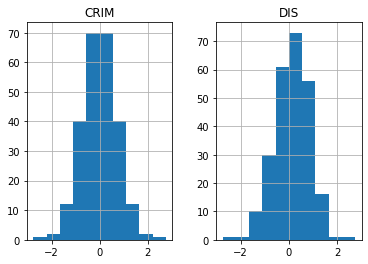

In [28]:
_ = pd.DataFrame(X_train_new, columns=['CRIM', 'DIS']).hist()

In [29]:
a = gauss_rank_scaler.inverse_transform(X_train_new)

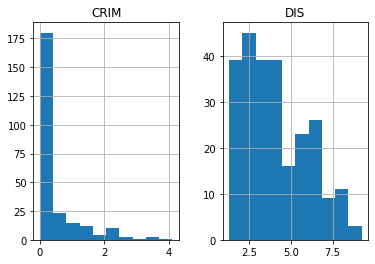

In [30]:
_ = pd.DataFrame(a, columns=['CRIM', 'DIS']).hist()

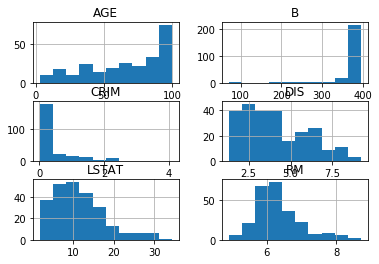

In [7]:
_ = X_train[['CRIM', 'RM', 'AGE', 'DIS', 'B', 'LSTAT']].hist()

In [ ]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GuassRankScaler(BaseEstimator, TransformerMixin):
    """Standardize features by removing the mean and scaling to unit variance
        The standard score of a sample `x` is calculated as:
            z = (x - u) / s
        where `u` is the mean of the training samples or zero if `with_mean=False`,
        and `s` is the standard deviation of the training samples or one if
        `with_std=False`.
        Centering and scaling happen independently on each feature by computing
        the relevant statistics on the samples in the training set. Mean and
        standard deviation are then stored to be used on later data using the
        `transform` method.
        Standardization of a dataset is a common requirement for many
        machine learning estimators: they might behave badly if the
        individual features do not more or less look like standard normally
        distributed data (e.g. Gaussian with 0 mean and unit variance).
        For instance many elements used in the objective function of
        a learning algorithm (such as the RBF kernel of Support Vector
        Machines or the L1 and L2 regularizers of linear models) assume that
        all features are centered around 0 and have variance in the same
        order. If a feature has a variance that is orders of magnitude larger
        that others, it might dominate the objective function and make the
        estimator unable to learn from other features correctly as expected.
        This scaler can also be applied to sparse CSR or CSC matrices by passing
        `with_mean=False` to avoid breaking the sparsity structure of the data.
        Read more in the :ref:`User Guide <preprocessing_scaler>`.
        Parameters
        ----------
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array or scipy.sparse CSR matrix, a copy may still be
            returned.
        with_mean : boolean, True by default
            If True, center the data before scaling.
            This does not work (and will raise an exception) when attempted on
            sparse matrices, because centering them entails building a dense
            matrix which in common use cases is likely to be too large to fit in
            memory.
        with_std : boolean, True by default
            If True, scale the data to unit variance (or equivalently,
            unit standard deviation).
        Attributes
        ----------
        scale_ : ndarray or None, shape (n_features,)
            Per feature relative scaling of the data. This is calculated using
            `np.sqrt(var_)`. Equal to ``None`` when ``with_std=False``.
            .. versionadded:: 0.17
               *scale_*
        mean_ : ndarray or None, shape (n_features,)
            The mean value for each feature in the training set.
            Equal to ``None`` when ``with_mean=False``.
        var_ : ndarray or None, shape (n_features,)
            The variance for each feature in the training set. Used to compute
            `scale_`. Equal to ``None`` when ``with_std=False``.
        n_samples_seen_ : int or array, shape (n_features,)
            The number of samples processed by the estimator for each feature.
            If there are not missing samples, the ``n_samples_seen`` will be an
            integer, otherwise it will be an array.
            Will be reset on new calls to fit, but increments across
            ``partial_fit`` calls.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_params = {'kind': interp_kind, 'copy': interp_copy, 'fill_value': 'extrapolate'}
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Compute the mean and std to be used for later scaling.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        ranks = np.argsort(np.argsort(X, axis=0), axis=0)
        bound = 1.0 - self.epsilon
        factors = np.max(ranks) / 2.0 * bound
        scaled_ranks = np.clip(ranks / factors - bound, -bound, bound)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit)(x) for x in X.T)
        return self
    
    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(x, scaled_rank, **self.interp_params)
        

    def transform(self, X, copy=None):
        """Perform standardization by centering and scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, **self.interp_params)
        return inv_interp_func(erf(x))
    
    def drop_duplicates(self, x):
        m = np.zeros_like(x, dtype=bool)
        m[np.unique(x, return_index=True)[1]] = True
        return x[m]

In [ ]:
def drop_duplicates(x):
    m = np.zeros_like(x, dtype=bool)
    m[np.unique(x, return_index=True)[1]] = True
    return x[m]

In [ ]:
a = np.array([1, 2, 1, 3, 3, 3, 0])
m = np.zeros_like(a, dtype=bool)
m[np.unique(a, return_index=True)[1]] = True
a[m]

In [ ]:
np.unique(a, return_index=True)[1]

In [ ]:
gauss_rank_scaler = GuassRankScaler()

In [ ]:
x = drop_duplicates(X_train['ZN'])
rank = np.argsort(np.argsort(x))
bound = 1.0 - 0.0001
factor = np.max(rank) / 2.0 * bound
scaled_rank = np.clip(rank / factor - bound, -bound, bound)

In [ ]:
a = gauss_rank_scaler.fit_transform(X_train[['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'B', 'LSTAT']])

In [ ]:
a[:, 2]

In [ ]:
np.argsort([1.0, 3.0, 2.0])

In [ ]:
from scipy.special import erfinv

class GaussRankScaler():

	def __init__( self ):
		self.epsilon = 0.001
		self.lower = -1 + self.epsilon
		self.upper =  1 - self.epsilon
		self.range = self.upper - self.lower

	def fit_transform( self, X ):
	
		i = np.argsort( X, axis = 0 )
		j = np.argsort( i, axis = 0 )

		assert ( j.min() == 0 ).all()
		assert ( j.max() == len( j ) - 1 ).all()
		
		j_range = len( j ) - 1
		self.divider = j_range / self.range
		
		transformed = j / self.divider
		transformed = transformed - self.upper
		transformed = erfinv( transformed )
		
		return transformed

In [ ]:
def build_rankgauss_trafo(x):
    finite_indices = np.isfinite(x)
    if np.sum(finite_indices) == 0:
        return np.array([]), np.array([])
    x_finite = x[np.isfinite(x)]
 
    hist = dict()
    for val in x_finite:
        hist[val] = hist.get(val, 0) + 1
 
    len_hist = len(hist)
    list_keys = list(hist.keys())
 
    if len_hist == 1:
        return np.array(list_keys), np.array([0.0])
    elif len_hist == 2:
        return np.array(list_keys), np.array([0.0, 1.0])
    else:
        hist = OrderedDict(sorted(hist.items()))    # sort by key
        n = float(x_finite.shape[0])
        cnt = 0.0
        mean = 0.0
        trafo_keys = list()
        trafo_values = list()
 
        for key, val in hist.items():
            # (notice) 'cnt / n * 0.998 + 1e-3' is always larger than zero
            rank_v = norm_cdf_inv(cnt / n * 0.998 + 1e-3) * 0.7
            trafo_keys.append(key)
            trafo_values.append(rank_v)
            mean += val * rank_v
            cnt += val
 
        mean /= n
        trafo_values = np.array(trafo_values)
        trafo_values -= mean
 
        return np.array(trafo_keys), trafo_values

In [ ]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GuassRankScaler(BaseEstimator, TransformerMixin):
    def __init__(self, epsilon=1e-4, kind='linear', copy=False, n_jobs=None):
        self.epsilon = epsilon
        self.interp_params = {'kind': kind, 'copy': copy, 'fill_value': 'extrapolate'}
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        ranks = np.argsort(np.argsort(X, axis=0), axis=0)
        bound = 1.0 - self.epsilon
        factors = np.max(ranks) / 2.0 * bound
        scaled_ranks = np.clip(ranks / factors - bound, -bound, bound)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(
            delayed(interp1d)(x, r, **self.interp_params) for x, r in zip(X.T, scaled_ranks.T))

        return self

    def transform(self, X):
        check_is_fitted(self, 'interp_func_')
        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)
        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T

        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X):
        check_is_fitted(self, 'interp_func_')
        X = check_array(X, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)
        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, **self.interp_params)
        return inv_interp_func(erf(x))

In [ ]:
scaler = GuassRankScaler(copy=True)

In [ ]:
X_tr = X_train[['CRIM', 'RM']]

In [ ]:
X_v = check_array(X_tr, dtype=FLOAT_DTYPES, force_all_finite=True)

In [ ]:
ranks = np.argsort(np.argsort(X_v, axis=0), axis=0)
bound = 1.0 - 0.0001
factors = np.max(ranks) / 2.0 * bound
scaled_ranks = np.clip(ranks / factors - bound, -bound, bound)


In [ ]:
a = []
for x, r in zip(X_v.T, scaled_ranks.T):
    a.append(interp1d(x, r, **interp_params))

In [ ]:
a[0].y

In [ ]:
interp_params = {'kind': 'linear', 'copy': False, 'fill_value': 'extrapolate'}

In [ ]:
interp_func_ = Parallel(n_jobs=None)(
    delayed(interp1d)(x, r, **interp_params) for x, r in (X_v.T, scaled_ranks.T))

In [ ]:
def _transform(i, x):
    return interp_func_[i](x)

In [ ]:
interp_func_[0].y

In [ ]:
Parallel(n_jobs=None)(delayed(_transform)(i, x) for i, x in enumerate(X_v.T))

In [ ]:
scaler.interp_func_

In [ ]:
ranks = np.argsort(np.argsort(X_tr, axis=0), axis=0)

In [ ]:

bound = 1.0 - 0.001
factor = np.max(ranks) / 2.0 * bound
scaled_ranks = np.clip(ranks / factor - bound, -bound, bound)

In [ ]:
a  = [(x, y) for x, y in (X_tr.values.T, scaled_ranks.values.T)]

In [ ]:
a[0][1]

In [ ]:
interp_func = interp1d(X_tr, scaled_ranks, kind='linear', fill_value='extrapolate')

In [ ]:
interp_func.x

In [ ]:
v = interp_func(X_train['CRIM'])

In [ ]:
scaled_ranks

In [ ]:
z = scaler.inverse_transform(v)

In [ ]:
X_train['CRIM'].hist()

In [ ]:
pd.Series(z).hist()

In [ ]:
v = scaler.fit_transform(X_tr)

In [ ]:
v

In [ ]:
pd.Series(vv[:, 0]).hist()

In [ ]:
X_train['CRIM'].hist()

In [ ]:
pd.Series(v).hist()

In [ ]:
X_train['CRIM']

In [ ]:
v[143]

In [ ]:
np.arange(v.shape[0])[~np.isfinite(v)]

In [ ]:
a = pd.Series(v)

In [ ]:
vv = a[a != np.inf]

In [ ]:
vv = scaler.inverse_transform(v)

In [ ]:
vv

In [ ]:
from sklearn.utils.validation import FLOAT_DTYPES, check_is_fitted
from sklearn.utils import check_array, check_random_state
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.interpolate import interp1d
from collections import OrderedDict
from numba import jit
 
 
try:
    from joblib import Parallel, delayed
except ImportError:
    from sklearn.externals.joblib import Parallel, delayed
 
 
class RankGaussScaler(BaseEstimator, TransformerMixin):
    def __init__(self, nan_to_val=None, extrapolate=False, num_storing=None,
                 random_state=None, interp_params=None, n_jobs=None):
        nan_to_val = nan_to_val or True
        self.nan_to_val = 0.0 if isinstance(nan_to_val, bool) else nan_to_val
        self.force_all_finite = False
        if isinstance(nan_to_val, bool) and not nan_to_val:
            self.force_all_finite = True
 
        self.extrapolate = extrapolate
        num_storing = num_storing or np.iinfo(int).max
        self.num_storing = 2 if num_storing < 2 else num_storing
        self.random_state = check_random_state(random_state)
        self.interp_params = interp_params or dict(kind='linear')
        self.n_jobs = n_jobs
 
    def fit(self, X, y=None):
        X = self._check_array(X)
        X = self._to_2d_if_1d(X)
 
        self.codebooks_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._make_codebook)(*x) for x in enumerate(X.T))
 
        return self
 
    def transform(self, X):
        transformed = self._transform(X, self._transform_column)
        if not self.force_all_finite:
            transformed[~np.isfinite(transformed)] = self.nan_to_val
        return transformed
 
    def inverse_transform(self, X):
        return self._transform(X, self._inv_transform_column)
 
    def _transform(self, X, func_transform):
        X = self._check_before_transform(X)
        return_as_1d = True if len(X.shape) == 1 else False
        X = self._to_2d_if_1d(X)
 
        transformed = np.array(
            Parallel(n_jobs=self.n_jobs)(
                delayed(func_transform)(*x, **self.interp_params)
                for x in enumerate(X.T))).T
 
        return self._to_1d_if_single(transformed) if return_as_1d \
            else transformed    # preserve input shape
 
    def _check_array(self, X):
        # validate input and return X as numpy format
        return check_array(X, dtype=FLOAT_DTYPES, ensure_2d=False,
                           force_all_finite=self.force_all_finite)
 
    def _check_num_cols(self, X):
        # validate input after fit()
        num_features = 1 if len(X.shape) == 1 else X.shape[1]
        if num_features != len(self.codebooks_):
            raise ValueError('bad input shape {0}'.format(X.shape))
 
    def _check_before_transform(self, X):
        check_is_fitted(self, 'codebooks_')    # check if 'codebooks_' exists
        X = self._check_array(X)       # check input type and structure
        self._check_num_cols(X)        # check # of columns
        return X
 
    def _make_codebook(self, col_index, x):
        codebook = build_rankgauss_trafo(x)
        num_codes = len(codebook[0])
 
        if num_codes == 0:
            raise ValueError('column %d contains only null values' % col_index)
        elif num_codes > self.num_storing:
            # first, select minimum and maximum, then choose the rest randomly
            chosen = self.random_state.choice(
                num_codes - 2, self.num_storing - 2, replace=False)
            chosen = np.append(np.array([0, num_codes - 1]), chosen + 1)
            return codebook[0][chosen], codebook[1][chosen]
        else:
            return codebook
 
    def _transform_column(self, index, x, **interp1d_params):
        return self._transform_with_interp(
            x, *self.codebooks_[index], **interp1d_params)
 
    def _inv_transform_column(self, index, x, **interp1d_params):
        return self._transform_with_interp(
            x, *reversed(self.codebooks_[index]), **interp1d_params)
 
    def _transform_with_interp(self, x, train_x, train_y, **interp1d_params):
        if len(train_x) == 1:
            return np.ones(x.shape) * train_y[0]
        f = interp1d(train_x, train_y, fill_value='extrapolate',
                     **interp1d_params)
        return f(x) if self.extrapolate else f(np.clip(x, *minmax(train_x)))
 
    @staticmethod
    def _to_2d_if_1d(a):
        return a.reshape(-1, 1) if len(a.shape) == 1 else a
 
    @staticmethod
    def _to_1d_if_single(a):
        return a.ravel() if a.shape[1] == 1 else a
 
 
# function for simultaneous max() and min() (using numba)
# https://stackoverflow.com/a/33919126
@jit
def minmax(x):
    maximum = x[0]
    minimum = x[0]
    for i in x[1:]:
        if i > maximum:
            maximum = i
        elif i < minimum:
            minimum = i
    return minimum, maximum
 
 
# converted from [ref 1]
@jit
def norm_cdf_inv(p):
    sign = 1.0
    if p < 0.5:
        sign = -1.0
    else:
        p = 1.0 - p
    t = np.sqrt(-2.0 * np.log(p))
    return sign * (t - ((0.010328 * t + 0.802853) * t + 2.515517) /
                   (((0.001308 * t + 0.189269) * t + 1.432788) * t + 1.0))
 
 
# converted from [ref 1]
@jit
def build_rankgauss_trafo(x):
    finite_indices = np.isfinite(x)
    if np.sum(finite_indices) == 0:
        return np.array([]), np.array([])
    x_finite = x[np.isfinite(x)]
 
    hist = dict()
    for val in x_finite:
        hist[val] = hist.get(val, 0) + 1
 
    len_hist = len(hist)
    list_keys = list(hist.keys())
 
    if len_hist == 1:
        return np.array(list_keys), np.array([0.0])
    elif len_hist == 2:
        return np.array(list_keys), np.array([0.0, 1.0])
    else:
        hist = OrderedDict(sorted(hist.items()))    # sort by key
        n = float(x_finite.shape[0])
        cnt = 0.0
        mean = 0.0
        trafo_keys = list()
        trafo_values = list()
 
        for key, val in hist.items():
            # (notice) 'cnt / n * 0.998 + 1e-3' is always larger than zero
            rank_v = norm_cdf_inv(cnt / n * 0.998 + 1e-3) * 0.7
            trafo_keys.append(key)
            trafo_values.append(rank_v)
            mean += val * rank_v
            cnt += val
 
        mean /= n
        trafo_values = np.array(trafo_values)
        trafo_values -= mean
 
        return np.array(trafo_keys), trafo_values

In [ ]:
gaussrankscaler = GaussRankScaler()

In [ ]:
%time
v = gaussrankscaler.fit_transform(X_train['CRIM'])

In [ ]:
rankgaussscaler = RankGaussScaler()

In [ ]:
%time
x = rankgaussscaler.fit_transform(X_train['CRIM'])

In [ ]:
x

In [ ]:
def convert_input(X, columns=None, deep=False):
    """
    Unite data into a DataFrame.
    Objects that do not contain column names take the names from the argument.
    Optionally perform deep copy of the data.
    """
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X, copy=deep)
        else:
            if columns is not None and np.size(X,1) != len(columns):
                raise ValueError('The count of the column names does not correspond to the count of the columns')
            if isinstance(X, list):
                X = pd.DataFrame(X, columns=columns, copy=deep)  # lists are always copied, but for consistency, we still pass the argument
            elif isinstance(X, (np.generic, np.ndarray)):
                X = pd.DataFrame(X, columns=columns, copy=deep)
            elif isinstance(X, csr_matrix):
                X = pd.DataFrame(X.todense(), columns=columns, copy=deep)
            else:
                raise ValueError('Unexpected input type: %s' % (str(type(X))))

            X = X.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    elif deep:
        X = X.copy(deep=True)

    return X

In [ ]:
import bisect
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder


class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.all_classes_ = None
        self.all_encoders_ = None

    def fit(self, X, y=None):
        """Fit encoder according to X and y.
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        Returns
        -------
        self : encoder
            Returns self.
        """

        # first check the type
        X = convert_input(X)
        
        self._dim = X.shape[1]

        # if columns aren't passed, just use every string column
        if self.cols is None:
            self.cols = util.get_obj_cols(X)
        else:
            self.cols = util.convert_cols_to_list(self.cols)
        
        if self.handle_missing == 'error':
            if X[self.cols].isnull().any().bool():
                raise ValueError('Columns to be encoded can not contain null')
        
        n = len(self.columns)
        self.all_classes_ = np.ndarray(shape=(n, ), dtype=object)
        self.all_encoders_ = np.ndarray(shape=(n, ), dtype=object)
        for i, column in enumerate(self.columns):
            le = LabelEncoder()
            le.fit(X[:, column].astype('str', copy=False))
            classes = le.classes_.tolist()
            bisect.insort_left(classes, '<unknown>')
            le.classes_ = classes
            self.all_classes_[i] = (column, np.array(le.classes_, dtype=object))
            self.all_encoders_[i] = le
        return self

    def transform(self, X, y=None):
        for i, column in enumerate(self.columns):
            X[:, column].astype('str')
            X[:, column] = np.where(np.isin(X[:, column], self.all_classes_[i][1]), X[:, column], '<unknown>')
            X[:, column] = self.all_encoders_[i].transform(X[:, column])
        return X

    def inverse_transform(self, X, y=None):
        for i, column in enumerate(self.columns):
            X[:, column] = self.all_encoders_[i].inverse_transform(X[:, column])
        return X

In [ ]:
# use target encoding to encode two categorical features
enc = MultiColumnLabelEncoder()
enc.fit(X_train[['CHAS', 'RAD']])

In [ ]:
# transform the datasets
training_numeric_dataset = enc.transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)